## Installations, Imports and Setup

In [ ]:
!pip install git+https://github.com/DLR-RM/stable-baselines3
!pip install highway_env

!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

#Imports and gym creation
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow import keras
import random
import highway_env

import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
import pandas as pd
import pickle

  Cloning https://github.com/DLR-RM/stable-baselines3 to /tmp/pip-req-build-9iehq8sj
  Running command git clone -q https://github.com/DLR-RM/stable-baselines3 /tmp/pip-req-build-9iehq8sj
     |████████████████████████████████| 1.5 MB 6.5 MB/s 
  Created wheel for stable-baselines3: filename=stable_baselines3-1.5.1a6-py3-none-any.whl size=165127 sha256=886cfb2323f0457d97dbaa21c028db4be94a73f8f4c578e569b5e01b19a9ed2c
  Stored in directory: /tmp/pip-ephem-wheel-cache-ilvkyoxi/wheels/2b/88/65/5d0cb266b061107af8c518096240bea8578e9843716f79e4da
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616828 sha256=11e17eaaccd4ccef29d6e5fd5a79961a8f866f5ba68bc05856a24b37935544eb
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
Successfully built stable-baselines3 gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
     |██████████

Configuring display for google colab

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1
      
def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env  

In [ ]:
LEARNING_RATE = 5e-4
directory = "drive/MyDrive/here/"

## Creating Model

###DQN

In [ ]:
class DQN():
  def __init__(self, state_space, action_space, epsilon):
    self.state_space = state_space
    self.action_space = action_space
    self.memory = deque([], maxlen=10000)
    self.epsilon = epsilon
    self.model = self.build_model()
    self.loss = []

  def build_model(self):
     model = keras.Sequential()
     model.add(keras.layers.Dense(24, input_dim=self.state_space, activation='relu'))
     model.add(keras.layers.Dense(24, activation='relu'))
     model.add(keras.layers.Dense(self.action_space, activation='linear'))
     model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=LEARNING_RATE))
     return model

  def action(self, state, env):
    if np.random.rand() <= self.epsilon:
      return random.randrange(self.action_space)
    action_vals = self.model.predict(state)
    return np.argmax(action_vals[0])

  def test_action(self, state): 
    action_vals = self.model.predict(state)
    return np.argmax(action_vals[0]) 

  def store(self, state, action, reward, nstate, done):
    self.memory.append((state, action, reward, nstate, done))

  def load(self):
    self.model.load_weights(FILENAME)

  def summary(self):
    self.model.summary()

  def save(self):
    self.model.save_weights(FILENAME)

  def experience_replay(self, batch_size):
    minibatch = random.sample(self.memory, batch_size)

    x = []
    y = []

    np_array = np.array(minibatch)
    state = np.zeros((0,self.state_space))
    next_state = np.zeros((0,self.state_space))
    for i in range(len(np_array)):
      state = np.append(state, np_array[i,0], axis=0)
      next_state = np.append(next_state, np_array[i,3], axis=0)

    state_predict = self.model.predict(state)
    next_state_predict = self.model.predict(next_state)
    index = 0

    for state, action, reward, nstate, done in minibatch:
      x.append(state)
      next_state_action_predict_model = next_state_predict[index]

      if done == True:
        target = reward
      else:
        target = reward + DISCOUNT_RATE * np.amax(next_state_action_predict_model)

      target_f = state_predict[index]
      target_f[action] = target
      y.append(target_f)
      index += 1

    x_reshape = np.array(x).reshape(batch_size,self.state_space)
    y_reshape = np.array(y)
    epoch_count = 1
    hist = self.model.fit(x_reshape, y_reshape, epochs=epoch_count, verbose=0)
    for i in range(epoch_count):
      self.loss.append(hist.history['loss'][i])
    if self.epsilon > EPSILON_MIN:
      self.epsilon *= EPSILON_DECAY

###DDQN

In [ ]:
class DDQN():
  def __init__(self, state_space, action_space, epsilon):
    self.state_space = state_space
    self.action_space = action_space
    self.memory = deque([], maxlen=10000)
    self.epsilon = epsilon
    self.model = self.build_model()
    self.model_target = self.build_model()
    self.update_target_from_model()
    self.loss = []

  def build_model(self):
     model = keras.Sequential()
     model.add(keras.layers.Dense(24, input_dim=self.state_space, activation='relu'))
     model.add(keras.layers.Dense(24, activation='relu'))
     model.add(keras.layers.Dense(self.action_space, activation='linear'))
     model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=LEARNING_RATE))
     return model

  def update_target_from_model(self):
        self.model_target.set_weights(self.model.get_weights())

  def action(self, state, env):
    if np.random.rand() <= self.epsilon:
      return random.randrange(self.action_space)
    action_vals = self.model.predict(state)
    return np.argmax(action_vals[0])

  def test_action(self, state): 
    action_vals = self.model.predict(state)
    return np.argmax(action_vals[0]) 

  def store(self, state, action, reward, nstate, done):
    self.memory.append((state, action, reward, nstate, done))

  def load(self):
    self.model.load_weights(FILENAME)

  def save(self):
    self.model.save_weights(FILENAME)

  def experience_replay(self, batch_size):
    minibatch = random.sample(self.memory, batch_size)

    x = []
    y = []

    np_array = np.array(minibatch)
    state = np.zeros((0,self.state_space))
    next_state = np.zeros((0,self.state_space))
    for i in range(len(np_array)):
      state = np.append(state, np_array[i,0], axis=0)
      next_state = np.append(next_state, np_array[i,3], axis=0)

    state_predict = self.model.predict(state)
    next_state_predict = self.model.predict(next_state)
    next_state_predict_target = self.model_target.predict(next_state)
    index = 0

    for state, action, reward, nstate, done in minibatch:
      x.append(state)
      next_state_action_predict_target = next_state_predict_target[index]
      next_state_action_predict_model = next_state_predict[index]

      if done == True:
        target = reward
      else:
        target = reward + DISCOUNT_RATE * next_state_action_predict_target[np.argmax(next_state_action_predict_model)]

      target_f = state_predict[index]
      target_f[action] = target
      y.append(target_f)
      index += 1

    x_reshape = np.array(x).reshape(batch_size,self.state_space)
    y_reshape = np.array(y)
    epoch_count = 1
    hist = self.model.fit(x_reshape, y_reshape, epochs=epoch_count, verbose=0)
    for i in range(epoch_count):
      self.loss.append(hist.history['loss'][i])
    if self.epsilon > EPSILON_MIN:
      self.epsilon *= EPSILON_DECAY

## Question 1

How does epsilon rate affects the training over a specific number of episode?


### DQN (Epsilon 0.05)

In [ ]:
EPISODES = 500
TRAIN_END = 0
DISCOUNT_RATE = 0.8
LEARNING_RATE = 5e-4
BATCH_SIZE = 32
EPSILON_MIN = 0.05
EPSILON_DECAY = 0.995

FILENAME = directory + "DQN_1"
SAVE_EVERY = 100

In [ ]:
env = gym.make('highway-fast-v0')
env.configure({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
    }
})
env.action_space.np_random.seed(123)
env.seed(50)
nS = len(env.reset().flatten())
nA = env.action_space.n
dqn = DQN(nS, nA, 1)

batch_size = BATCH_SIZE

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
rewardsFirstEpsilon = [] 
episodes = [] 
step = 0

for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    done = False
    while not done:
        action = dqn.action(state,env)
        nstate, reward, done, _ = env.step(action)
        nstate = np.reshape(nstate, [1, nS])
        tot_rewards += reward
        dqn.store(state, action, reward, nstate, done)
        state = nstate
        if done:
            rewardsFirstEpsilon.append(tot_rewards)
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e, EPISODES, tot_rewards, dqn.epsilon))
            break
        if len(dqn.memory) > batch_size:
            dqn.experience_replay(batch_size)
    if step % SAVE_EVERY == 0:
       dqn.save()

    step += 1

episode: 0/500, score: 8.753095795496424, e: 1
episode: 1/500, score: 9.246450885166432, e: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


episode: 2/500, score: 8.264240939195599, e: 0.995
episode: 3/500, score: 19.579118533946005, e: 0.8822202429488013
episode: 4/500, score: 9.185929265169712, e: 0.8348931673187264
episode: 5/500, score: 8.285973408449017, e: 0.798065677681905
episode: 6/500, score: 11.348454096506138, e: 0.7402609576967045
episode: 7/500, score: 2.046796163638108, e: 0.7328768546436799
episode: 8/500, score: 8.663617683464741, e: 0.6935613678313175
episode: 9/500, score: 5.446446298431657, e: 0.6730128848950395
episode: 10/500, score: 6.079306992401456, e: 0.653073201944699
episode: 11/500, score: 1.9130006968016173, e: 0.6465587967553006
episode: 12/500, score: 16.579294623116226, e: 0.5790496471185967
episode: 13/500, score: 10.27868460429184, e: 0.547986285490042
episode: 14/500, score: 3.713118245382063, e: 0.5371084840724134
episode: 15/500, score: 2.0190270966283355, e: 0.531750826943791
episode: 16/500, score: 4.913417452866392, e: 0.5185893309484582
episode: 17/500, score: 4.245751780009306, e:

### DQN (Epsilon 1e-5)

In [ ]:
EPISODES = 500
TRAIN_END = 0
DISCOUNT_RATE = 0.8
LEARNING_RATE = 5e-4
BATCH_SIZE = 32
EPSILON_MIN = 0.00001
EPSILON_DECAY = 0.995

FILENAME = directory + "DQN_2"
SAVE_EVERY = 50

In [ ]:
env = gym.make('highway-fast-v0')
env.configure({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
    }
})
env.action_space.np_random.seed(123)
env.seed(50)
nS = len(env.reset().flatten())
nA = env.action_space.n
dqn = DQN(nS, nA, 1)

batch_size = BATCH_SIZE

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
rewardsSecondEpsilon = [] 
episodes = [] 
step = 0

for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    done = False
    while not done:
        action = dqn.action(state,env)
        nstate, reward, done, _ = env.step(action)
        nstate = np.reshape(nstate, [1, nS])
        tot_rewards += reward
        dqn.store(state, action, reward, nstate, done)
        state = nstate
        if done:
            rewardsSecondEpsilon.append(tot_rewards)
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e, EPISODES, tot_rewards, dqn.epsilon))
            break
        if len(dqn.memory) > batch_size:
            dqn.experience_replay(batch_size)
    if step % SAVE_EVERY == 0:
       dqn.save()

    step += 1

episode: 0/500, score: 4.679313079982055, e: 1
episode: 1/500, score: 4.915196919174903, e: 1
episode: 2/500, score: 4.130931283008172, e: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


episode: 3/500, score: 16.486319003526447, e: 0.960693043575437
episode: 4/500, score: 10.634796153151683, e: 0.8955869907338783
episode: 5/500, score: 3.879202726624439, e: 0.8778091417340573
episode: 6/500, score: 7.46484440927529, e: 0.8390886103705794
episode: 7/500, score: 3.8868817546179377, e: 0.8183201210226743
episode: 8/500, score: 7.418668491004058, e: 0.778312557068642
episode: 9/500, score: 8.646170281993946, e: 0.736559652908221
episode: 10/500, score: 1.8993780516752843, e: 0.7292124703704616
episode: 11/500, score: 5.88499458980149, e: 0.7076077347272662
episode: 12/500, score: 8.231468666403332, e: 0.6730128848950395
episode: 13/500, score: 2.812261207255445, e: 0.6629680834613705
episode: 14/500, score: 9.179785712849506, e: 0.6242658676435396
episode: 15/500, score: 4.332710610238158, e: 0.6088145090359074
episode: 16/500, score: 8.43271060945776, e: 0.5790496471185967
episode: 17/500, score: 5.000045377438382, e: 0.5618938591163328
episode: 18/500, score: 2.4, e: 0.

### DQN (Epsilon 0.9)

In [ ]:
EPISODES = 500
TRAIN_END = 0
DISCOUNT_RATE = 0.8
LEARNING_RATE = 5e-4
BATCH_SIZE = 32
EPSILON_MIN = 0.9
EPSILON_DECAY = 0.995

FILENAME = directory + "DQN_3"
SAVE_EVERY = 50

In [ ]:
env = gym.make('highway-fast-v0')
env.configure({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
    }
})
env.action_space.np_random.seed(123)
env.seed(50)
nS = len(env.reset().flatten())
nA = env.action_space.n
dqn = DQN(nS, nA, 1)

batch_size = BATCH_SIZE

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
rewardsThirdEpsilon = [] 
episodes = [] 
step = 0

for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    done = False
    while not done:
        action = dqn.action(state,env)
        nstate, reward, done, _ = env.step(action)
        nstate = np.reshape(nstate, [1, nS])
        tot_rewards += reward
        dqn.store(state, action, reward, nstate, done)
        state = nstate
        if done:
            rewardsThirdEpsilon.append(tot_rewards)
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e, EPISODES, tot_rewards, dqn.epsilon))
            break
        if len(dqn.memory) > batch_size:
            dqn.experience_replay(batch_size)
    if step % SAVE_EVERY == 0:
       dqn.save()

    step += 1

episode: 0/500, score: 5.399482916639, e: 1
episode: 1/500, score: 9.530223349369795, e: 1
episode: 2/500, score: 5.6324506849377425, e: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


episode: 3/500, score: 10.864048132597341, e: 0.9558895783575597
episode: 4/500, score: 6.832520430091834, e: 0.9229311239742362
episode: 5/500, score: 8.700811759059096, e: 0.8955869907338783
episode: 6/500, score: 7.179045161909473, e: 0.8955869907338783
episode: 7/500, score: 3.286537169695225, e: 0.8955869907338783
episode: 8/500, score: 5.51516028641246, e: 0.8955869907338783
episode: 9/500, score: 7.264472934730478, e: 0.8955869907338783
episode: 10/500, score: 7.398245867898388, e: 0.8955869907338783
episode: 11/500, score: 20.912335901824488, e: 0.8955869907338783
episode: 12/500, score: 25.3818042581216, e: 0.8955869907338783
episode: 13/500, score: 8.54445177109734, e: 0.8955869907338783
episode: 14/500, score: 3.6306765444218434, e: 0.8955869907338783
episode: 15/500, score: 3.482746188728289, e: 0.8955869907338783
episode: 16/500, score: 8.345815475781853, e: 0.8955869907338783
episode: 17/500, score: 10.115190232782178, e: 0.8955869907338783
episode: 18/500, score: 2.51577

### Saving logs

In [ ]:
open_file = open(directory + "rewardsFirstEpsilon.pkl", "wb")
pickle.dump(rewardsFirstEpsilon, open_file)
open_file.close()

open_file = open(directory + "rewardsSecondEpsilon.pkl", "wb")
pickle.dump(rewardsSecondEpsilon, open_file)
open_file.close()

open_file = open(directory + "rewardsThirdEpsilon.pkl", "wb")
pickle.dump(rewardsThirdEpsilon, open_file)
open_file.close()

### Plots for Question 1

Loading Saved Logs

In [ ]:
open_file = open(directory + "rewardsFirstEpsilon.pkl", "rb")
rewardsFirstEpsilon = pickle.load(open_file)
open_file.close()

open_file = open(directory + "rewardsSecondEpsilon.pkl", "rb")
rewardsSecondEpsilon = pickle.load(open_file)
open_file.close()

open_file = open(directory + "rewardsThirdEpsilon.pkl", "rb")
rewardsThirdEpsilon = pickle.load(open_file)
open_file.close()

Plots

In [ ]:
one = pd.Series(rewardsFirstEpsilon, name="rewards")
two = pd.Series(rewardsSecondEpsilon, name="rewards")
three = pd.Series(rewardsThirdEpsilon, name="rewards")

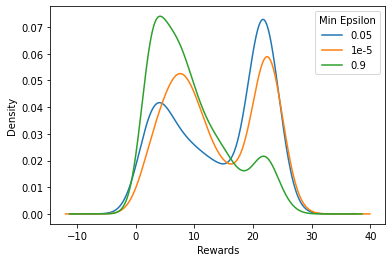

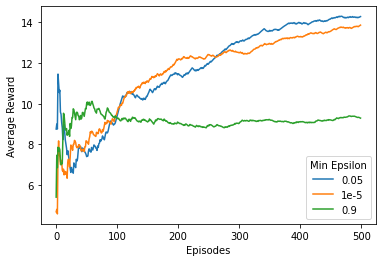

In [ ]:
fig, ax = plt.subplots()

one.plot(kind="kde", label="0.05")
two.plot(kind="kde", label="1e-5")
three.plot(kind="kde", label="0.9")
ax.set_xlabel("Rewards")
ax.legend(title="Min Epsilon")
plt.show()

fig, ax = plt.subplots()

(one.expanding()
               .mean()
               .plot(label="0.05"))
(two.expanding()
                      .mean()
                      .plot(label="1e-5"))
(three.expanding()
                      .mean()
                      .plot(label="0.9"))
ax.set_xlabel("Episodes")
ax.set_ylabel("Average Reward")
ax.legend(title="Min Epsilon")
plt.show()

## Question 2
Which model converge faster over a specific number of episode?

### DDQN


In [ ]:
EPISODES = 500
TRAIN_END = 0
DISCOUNT_RATE = 0.8
LEARNING_RATE = 5e-4
BATCH_SIZE = 32
EPSILON_MIN = 0.05
EPSILON_DECAY = 0.995

FILENAME = directory + "DDQN"
SAVE_EVERY = 50

In [ ]:
env = gym.make('highway-fast-v0')
env.configure({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
    }
})
env.action_space.np_random.seed(123)
env.seed(50)
nS = len(env.reset().flatten())
nA = env.action_space.n
ddqn = DDQN(nS, nA, 1)

batch_size = BATCH_SIZE

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
rewardsDDQN = []
step = 0

for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    done = False
    while not done:
        action = ddqn.action(state,env)
        nstate, reward, done, _ = env.step(action)
        nstate = np.reshape(nstate, [1, nS])
        tot_rewards += reward
        ddqn.store(state, action, reward, nstate, done) # Resize to store in memory to pass to .predict
        state = nstate
        if done:
            rewardsDDQN.append(tot_rewards)
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e, EPISODES, tot_rewards, ddqn.epsilon))
            break
        if len(ddqn.memory) > batch_size:
            ddqn.experience_replay(batch_size)
    

    if e % SAVE_EVERY == 0:
      ddqn.save()
    
    ddqn.update_target_from_model()

    step += 1

episode: 0/500, score: 9.61191662071347, e: 1
episode: 1/500, score: 7.446036834410233, e: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


episode: 2/500, score: 16.429974033576283, e: 0.9511101304657719
episode: 3/500, score: 11.284232901632022, e: 0.8866535105013078
episode: 4/500, score: 3.365378591649179, e: 0.8690529955452602
episode: 5/500, score: 16.87749455150354, e: 0.7861544476842928
episode: 6/500, score: 7.879476114053639, e: 0.7477194593032545
episode: 7/500, score: 13.143958752491539, e: 0.697046600835495
episode: 8/500, score: 4.9333280530495935, e: 0.6763948591909945
episode: 9/500, score: 5.67930684533812, e: 0.6563549768288433
episode: 10/500, score: 6.1806080981674345, e: 0.6337242817644086
episode: 11/500, score: 11.865776501256276, e: 0.5819594443402982
episode: 12/500, score: 4.646446298431657, e: 0.567555222460375
episode: 13/500, score: 2.6467961636381085, e: 0.5590843898207511
episode: 14/500, score: 9.880577223261794, e: 0.5238143793828016
episode: 15/500, score: 6.7856053287400675, e: 0.500708706245853
episode: 16/500, score: 9.984557153458844, e: 0.47622912292284103
episode: 17/500, score: 6.64

### Saving logs

In [ ]:
open_file = open(directory + "rewardsDDQN.pkl", "wb")
pickle.dump(rewardsDDQN, open_file)
open_file.close()

### Plots for Question 2

Which model performs better during training?

Loading Saved Logs

In [ ]:
open_file = open(directory + "rewardsDDQN.pkl", "rb")
rewardsDDQN = pickle.load(open_file)
open_file.close()

Plots

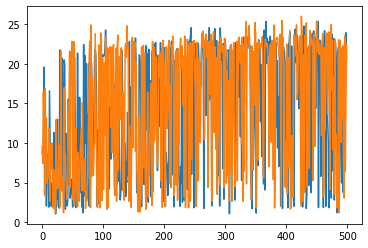

In [ ]:
plt.plot(rewardsFirstEpsilon)
plt.plot(rewardsDDQN)
plt.show()

In [ ]:
one = pd.Series(rewardsFirstEpsilon, name="scores")
two = pd.Series(rewardsDDQN, name="scores")

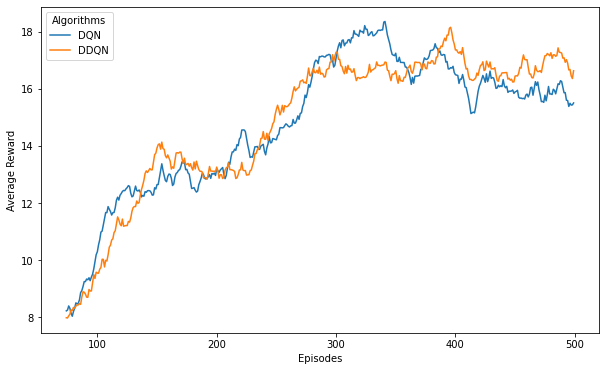

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
_ = (one.rolling(75)
               .mean()
               .plot(label="DQN"))
_ = (two.rolling(75)
                      .mean()
                      .plot(label="DDQN"))
_ = axes.set_xlabel("Episodes")
_ = axes.set_ylabel("Average Reward")
_ = axes.legend(title="Algorithms")

In [ ]:
print(np.mean(rewardsFirstEpsilon))
print(np.mean(rewardsDDQN))

14.290895696460412
14.408068326302212


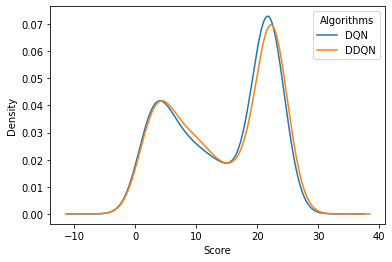

In [ ]:
fig, ax = plt.subplots(1,1)
_ = one.plot(kind="kde", ax=ax, label="DQN")
_ = two.plot(kind="kde", ax=ax, label="DDQN")
_ = ax.set_xlabel("Score")
_ = ax.legend(title="Algorithms")

## Question 3

What is the difference in performance between DQN and DDQN when testing on unseen seed and seed that is trained on over a specific number of episode?

Testing params for question 4.

In [ ]:
actionDQN = []
actionDDQN = []
actionRandomAction = []

speedDQN = []
speedDDQN = []
speedRandomAction = []

### Same Seed

#### DQN

In [ ]:
env = gym.make('highway-fast-v0')
env.configure({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
    }
})
env.seed(50)
env.action_space.np_random.seed(123)
env = wrap_env(env, video_callable=lambda episode_id:100)
nS = len(env.reset().flatten())
nA = env.action_space.n

In [ ]:
TEST_Episodes = 100
FILENAME = directory + "DQN_1"
dqn = DQN(nS, nA, 1)
dqn.load()
total_reward = 0
step = 0
rewards1_same_seed = []
for e_test in range(TEST_Episodes):
    state = env.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    done = False
    while not done:
        env.render()
        action = dqn.test_action(state)
        actionDQN.append(action)
        nstate, reward, done, info = env.step(action)
        speedDQN.append(info["speed"])
        nstate = np.reshape( nstate, [1, nS])
        tot_rewards += reward
        state = nstate
        if done:
          print(tot_rewards)
          rewards1_same_seed.append(tot_rewards)
          break;
        step += 1

env.close()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21.620221169036334
23.484575631714225
2.846020961436447
6.379830289487112
10.81721451488668
22.97983109028843
5.779784912048729
2.666666666666667
4.698372538695688
20.853554502338024
23.220221169036343
22.81959844516077
7.717640366114194
2.113158342536706
20.42022116903634
7.669329536422397
15.066627370313348
22.79738938932823
2.4
8.199331644636679
0.9491083676268862
22.120221153565748
22.020221169036347
5.6484281825825375
23.22022116903634
21.750891646260232
4.4
17.70266089887801
23.08688783570301
5.9131175500360555
17.502662869996556
14.38248786531281
14.330677345223169
15.345973384580402
6.26749905407372
22.400350666007782
22.82022116903634
19.553083676736872
1.7000000000000002
23.31927256532916
13.253554502369584
10.753554502365493
22.886265111013632
11.646445497871154
9.41720763486076
20.42022116903634
4.352985925448536
23.88626499252089
3.6306765444218434
22.55355450236968
7.899372437104327
10.48688771840535
6.5131121781841195
21.220221169032158
20.686887835702933
1.8467961636381

#### DDQN

In [ ]:
env = gym.make('highway-fast-v0')
env.configure({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
    }
})
env = wrap_env(env, video_callable=lambda episode_id:100)
env.seed(50)
env.action_space.np_random.seed(123)
nS = len(env.reset().flatten())
nA = env.action_space.n

In [ ]:
TEST_Episodes = 100
FILENAME = directory + "DDQN"
ddqn = DDQN(nS, nA, 1)
ddqn.load()
total_reward = 0
step = 0
rewards2_same_seed = []
for e_test in range(TEST_Episodes):
    state = env.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    done = False
    while not done:
        env.render()
        action = ddqn.test_action(state)
        actionDDQN.append(action)
        nstate, reward, done, info = env.step(action)
        speedDDQN.append(info["speed"])
        nstate = np.reshape( nstate, [1, nS])
        tot_rewards += reward
        state = nstate
        if done:
          print(tot_rewards)
          rewards2_same_seed.append(tot_rewards)
          break;
        step += 1

env.close()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20.42022116903634
7.666620490255715
5.999377276125195
22.618974343002602
21.918931450989977
14.733559394842647
6.399999213085794
2.666666666666667
7.353554486685507
24.252596021219194
24.553554502365497
25.99937727612444
8.211869443060886
23.052265602893854
4.379825009203373
20.918704762266437
4.153111909041576
22.420221169036346
7.01182383995658
9.599377276124432
11.16542121887337
20.98497763283877
23.81626859951357
5.77868456275905
22.953554502369677
10.93271060402193
3.6666683497571086
17.365377767190854
25.165377767763143
23.67849519400654
25.69644507477039
14.465377767190851
22.286887835703013
21.19937851818937
21.45355450212885
20.53599620332989
23.620221169036334
23.086265111827437
9.379156907889419
13.032044433857518
21.22022116903634
3.533333333333333
5.91249068251939
23.919022613103092
11.46666666666667
11.852265602653025
22.286887835703013
24.41959844516022
4.646446298431657
22.75320328060373
22.28626511101364
20.552931778494106
20.553554502369675
22.420221169036342
20.55355

#### Random Action

In [ ]:
env = gym.make('highway-fast-v0')
env.configure({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
    }
})
env = wrap_env(env, video_callable=lambda episode_id:100)
env.action_space.np_random.seed(123)
env.seed(50)

nS = len(env.reset().flatten())
nA = env.action_space.n

In [ ]:
TEST_Episodes = 100
total_reward = 0
step = 0
rewards3_same_seed = []
for e_test in range(TEST_Episodes):
    env.reset()
    tot_rewards = 0
    done = False
    while not done:
        env.render()
        action = random.randrange(5)
        actionRandomAction.append(action)
        nstate, reward, done, info = env.step(action)
        speedRandomAction.append(info["speed"])
        tot_rewards += reward
        if done:
          print(tot_rewards)
          rewards3_same_seed.append(tot_rewards)
          break;
        step += 1
        
env.close()

5.879785698962935
15.96274565720714
6.865515469889406
4.31955334018522
7.715197700136809
21.465394064684368
2.8130006968016175
4.586539422940191
4.9131643181664515
14.245186104897906
6.978684717163301
17.264578683935834
2.565420617691566
10.816796788792312
4.41195671948736
9.179779035101962
4.878856429045264
22.330568096937277
19.810457602826396
18.176333946981064
1.6327113850086175
3.580129496971442
8.34518921352981
11.379381498620646
3.513992753232264
11.030669805688252
9.102654345588864
8.61117814699547
24.927046431384692
5.632758414751405
8.917863212497641
4.181194875387091
8.645144942463107
5.9186417896190076
4.930671264138104
12.152028651607287
10.001991508724162
1.2130006968016174
22.76155890317084
14.5840721544195
21.83099219097826
12.432447609147852
9.379090949068727
6.8459742252837374
2.6333333333333333
4.230757822754315
3.2980905710429083
2.846020961436447
6.779825009203373
3.146020961436447
6.744788742302581
2.912239179751355
6.5817613860584885
4.181240077914714
14.25289058

### Different Seed


#### DQN

In [ ]:
env = gym.make('highway-fast-v0')
env.configure({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
    }
})
env.action_space.np_random.seed(123)
env.seed(1111)
env = wrap_env(env, video_callable=lambda episode_id:100)
nS = len(env.reset().flatten())
nA = env.action_space.n

In [ ]:
TEST_Episodes = 100
FILENAME = "drive/MyDrive/here/DQN_1"
dqn = DQN(nS, nA, 1)
dqn.load()
total_reward = 0
step = 0
rewards1_different_seed = []
for e_test in range(TEST_Episodes):
    state = env.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    done = False
    while not done:
        env.render()
        action = dqn.test_action(state)
        actionDQN.append(action)
        nstate, reward, done, info = env.step(action)
        speedDQN.append(info["speed"])
        nstate = np.reshape( nstate, [1, nS])
        tot_rewards += reward
        state = nstate
        if done:
          print(tot_rewards)
          rewards1_different_seed.append(tot_rewards)
          break;
        step += 1
env.close()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23.414836800825515
22.752660788430852
11.51906395682804
16.620221169008797
11.219652336859806
14.867042363228967
23.452253747139792
12.78688783570245
23.452265602893842
21.086887835703006
21.34816931508616
23.086887835703006
11.412885515944273
8.39733793080477
23.319327400581557
13.479779725161864
5.363053012067073
7.147801989238777
10.353502348500218
1.8467961636381087
9.912489881958889
6.7126813916096095
2.66404997490982
24.235224196215597
21.986887835703005
22.686887835703008
3.517213714117068
1.2467961636381084
21.102660898878014
15.819598445160215
5.063382314892505
9.24586895199447
22.952931778494104
22.020221168764422
24.152932219790742
20.55355380540819
3.713118245382063
10.353554502369658
22.28688694544936
22.15355450236968
6.629382834342367
4.912640986066761
23.220221169036332
5.800848534555979
5.9306712641381045
10.399377272977262
4.8464462984316565
1.0643544626778891
5.066666575098469
3.7467961636381086
2.9154705465254835
23.75355450236967
22.15355450236968
24.14521271741995

#### DDQN

In [ ]:
env = gym.make('highway-fast-v0')
env.configure({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
    }
})
env.seed(1111)
env = wrap_env(env, video_callable=lambda episode_id:100)
env.action_space.np_random.seed(123)
nS = len(env.reset().flatten())
nA = env.action_space.n

In [ ]:
TEST_Episodes = 100
FILENAME = "drive/MyDrive/here/DDQN"
print('Training complete. Testing started...')
ddqn = DDQN(nS, nA, 1)
ddqn.load()
total_reward = 0
step = 0
rewards2_different_seed = []
for e_test in range(TEST_Episodes):
    state = env.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    done = False
    while not done:
        env.render()
        action = ddqn.test_action(state)
        actionDDQN.append(action)
        nstate, reward, done, info = env.step(action)
        speedDDQN.append(info["speed"])
        nstate = np.reshape( nstate, [1, nS])
        tot_rewards += reward
        state = nstate
        if done:
          print(tot_rewards)
          rewards2_different_seed.append(tot_rewards)
          break;
        step += 1

env.close()

Training complete. Testing started...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23.052265602893854
12.199377276124434
4.646446298431657
22.15355450236968
25.084437766047472
20.42022116903634
23.55180223269378
14.932710609457768
5.945498700568959
23.62022106175227
22.817908965047483
25.498711924982604
4.9124959628031295
23.220221169036336
23.352931778494096
23.732711048957356
6.098711100524181
3.713118245382063
23.197422246885505
24.118932269560503
23.619598445160765
6.565933798286682
2.7798250092033725
24.05168551860411
24.819598444919947
11.46666666666667
23.219598445160766
19.966043942791107
3.734181867889313
5.179157349186058
7.866043942791098
23.086265111827437
18.73145962602536
23.886887835703
20.999377276124438
22.553554502369675
5.6
2.666666666666667
22.68626511182744
22.26408913050808
8.698711100524182
13.431421709981988
9.78293644586815
12.62022116900462
8.000000000000002
10.831421709981987
21.35293221979074
22.28430921818082
5.620168923598683
24.418352998754457
6.486881754617937
25.08688782181589
20.51902261310726
6.169322760232149
24.82022116721121
23.1

#### Random Action

In [ ]:
env = gym.make('highway-fast-v0')
env.configure({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
    }
})
env.seed(1111)
env = wrap_env(env, video_callable=lambda episode_id:100)
env.action_space.np_random.seed(123)
nS = len(env.reset().flatten())
nA = env.action_space.n

In [ ]:
TEST_Episodes = 100
total_reward = 0
step = 0
rewards3_different_seed = []
for e_test in range(TEST_Episodes):
    env.reset()
    tot_rewards = 0
    done = False
    while not done:
        env.render()
        action = random.randrange(5)
        actionRandomAction.append(action)
        nstate, reward, done, info = env.step(action)
        speedRandomAction.append(info["speed"])
        tot_rewards += reward
        if done:
          print(tot_rewards)
          rewards3_different_seed.append(tot_rewards)
          break;
        step += 1

env.close()

8.05006717456489
9.844278126148062
8.981761533278599
4.266043942791861
22.01559499364693
10.918989701254821
21.24970998237581
5.814887425457218
1.8467961636381087
7.814486958718196
8.545515675282234
3.4327113850086177
9.098221880904015
5.945973604704381
20.363312489244937
21.683211367256725
4.5483013656830344
2.7130006968016174
3.2485610015242012
10.518296175235092
16.897652580267078
14.877747015979542
2.5491083676268858
1.6327113850086175
23.11082763643225
7.9690574033325134
9.345828843241152
17.47852634079034
5.345979746648721
3.66404997490982
2.018315462896295
16.681447481915367
3.6985601993261055
9.547276802532021
3.5859548614734416
5.498773123941987
6.286840870549089
3.382786285882932
1.9801294969714418
2.913462830304775
4.246836260792752
11.545077799061636
10.030335250076279
11.478459827296216
12.235989382429212
10.377584463974527
4.912178739321495
1.5999999999999999
5.132072213624101
4.37936919360736
10.133339414418385
3.853548421284604
2.046796163638108
5.579778936418984
21.196

### Saving logs

In [ ]:
open_file = open(directory + "actionDQN.pkl", "wb")
pickle.dump(actionDQN, open_file)
open_file.close()

open_file = open(directory + "actionDDQN.pkl", "wb")
pickle.dump(actionDDQN, open_file)
open_file.close()

open_file = open(directory + "actionRandomAction.pkl", "wb")
pickle.dump(actionRandomAction, open_file)
open_file.close()

open_file = open(directory + "speedDQN.pkl", "wb")
pickle.dump(speedDQN, open_file)
open_file.close()

open_file = open(directory + "speedDDQN.pkl", "wb")
pickle.dump(speedDDQN, open_file)
open_file.close()

open_file = open(directory + "speedRandomAction.pkl", "wb")
pickle.dump(speedRandomAction, open_file)
open_file.close()

open_file = open(directory + "rewards1_same_seed.pkl", "wb")
pickle.dump(rewards1_same_seed, open_file)
open_file.close()

open_file = open(directory + "rewards2_same_seed.pkl", "wb")
pickle.dump(rewards2_same_seed, open_file)
open_file.close()

open_file = open(directory + "rewards3_same_seed.pkl", "wb")
pickle.dump(rewards3_same_seed, open_file)
open_file.close()

open_file = open(directory + "rewards1_different_seed.pkl", "wb")
pickle.dump(rewards1_different_seed, open_file)
open_file.close()

open_file = open(directory + "rewards2_different_seed.pkl", "wb")
pickle.dump(rewards2_different_seed, open_file)
open_file.close()

open_file = open(directory + "rewards3_different_seed.pkl", "wb")
pickle.dump(rewards3_different_seed, open_file)
open_file.close()

### Plot for Question 3

What is the difference in performance between DQN and DDQN when testing on unseen seen and seed that is trained on?

Loading Logs

In [ ]:
open_file = open(directory + "here/rewards1_same_seed.pkl", "rb")
rewards1_same_seed = pickle.load(open_file)
open_file.close()

open_file = open(directory + "rewards2_same_seed.pkl", "rb")
rewards2_same_seed = pickle.load(open_file)
open_file.close()

open_file = open(directory + "rewards3_same_seed.pkl", "rb")
rewards3_same_seed = pickle.load(open_file)
open_file.close()

open_file = open(directory + "rewards1_different_seed.pkl", "rb")
rewards1_different_seed = pickle.load(open_file)
open_file.close()

open_file = open(directory + "rewards2_different_seed.pkl", "rb")
rewards2_different_seed = pickle.load(open_file)
open_file.close()

open_file = open(directory + "rewards3_different_seed.pkl", "rb")
rewards3_different_seed = pickle.load(open_file)
open_file.close()

Plotting

In [ ]:
one = pd.Series(rewards1_same_seed, name="rewards")
two = pd.Series(rewards2_same_seed, name="rewards")
three = pd.Series(rewards3_same_seed, name="rewards")

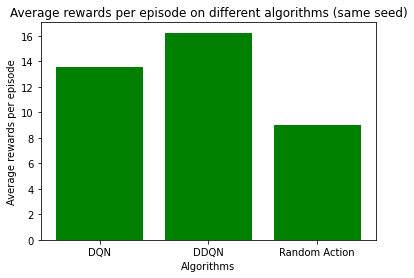

13.572871363682616
16.23737626948588
8.972079715899499


In [ ]:
mean1 = np.mean(rewards1_same_seed)
mean2 = np.mean(rewards2_same_seed)
mean3 = np.mean(rewards3_same_seed)

X = ["DQN", "DDQN", "Random Action"]
Y = [mean1, mean2, mean3]

plt.bar(X, Y, color='green')
plt.xlabel("Algorithms")
plt.ylabel("Average rewards per episode")
plt.title("Average rewards per episode on different algorithms (same seed)")

plt.show()
print(mean1)
print(mean2)
print(mean3)

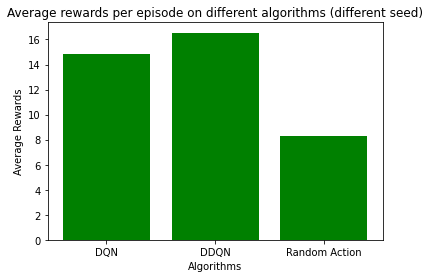

14.837746631126775
16.538537038269535
8.315741721605873


In [ ]:
mean1 = np.mean(rewards1_different_seed)
mean2 = np.mean(rewards2_different_seed)
mean3 = np.mean(rewards3_different_seed)

X = ["DQN", "DDQN", "Random Action"]
Y = [mean1, mean2, mean3]

plt.bar(X, Y, color='green')
plt.xlabel("Algorithms")
plt.ylabel("Average Rewards")
plt.title("Average rewards per episode on different algorithms (different seed)")

plt.show()
print(mean1)
print(mean2)
print(mean3)

## Question 4

Is there any emergent behavior on both models?

Loading Logs


In [ ]:
open_file = open(directory + "actionDQN.pkl", "rb")
actionDQN = pickle.load(open_file)
open_file.close()

open_file = open(directory + "actionDDQN.pkl", "rb")
actionDDQN = pickle.load(open_file)
open_file.close()

open_file = open(directory + "actionRandomAction.pkl", "rb")
actionRandomAction = pickle.load(open_file)
open_file.close()

open_file = open(directory + "speedDQN.pkl", "rb")
speedDQN = pickle.load(open_file)
open_file.close()

open_file = open(directory + "speedDDQN.pkl", "rb")
speedDDQN = pickle.load(open_file)
open_file.close()

open_file = open(directory + "speedRandomAction.pkl", "rb")
speedRandomAction = pickle.load(open_file)
open_file.close()

In [ ]:
one = pd.Series(actionDQN, name="rewards").value_counts()
two = pd.Series(actionDDQN, name="rewards").value_counts()
three = pd.Series(actionRandomAction, name="rewards").value_counts()

print(one)
print(two)
print(three)

1    1521
4    1096
2     520
3     508
0     102
Name: rewards, dtype: int64
1    1946
0     895
4     654
2     525
3     214
Name: rewards, dtype: int64
0    476
3    472
4    467
1    458
2    429
Name: rewards, dtype: int64


In [ ]:
[one[i] if i in one else 0 for i in range(5)]
[two[i] if i in two else 0 for i in range(5)]

[895, 1946, 525, 214, 654]

Plots

In [ ]:
one = pd.Series(actionDQN, name="rewards").value_counts()
two = pd.Series(actionDDQN, name="rewards").value_counts()
three = pd.Series(actionRandomAction, name="rewards").value_counts()

oneArr = [one[0], one[1], one[2], one[3], one[4]]
twoArr = [two[0], two[1], two[2], two[3], two[4]]
threeArr = [three[0], three[1], three[2], three[3], three[4]]

Text(0.52, 0, 'Action List: 0 - Left Lane, 1 - Idle, 2 - Right Lane, 3 - Faster, 4 - Slower')

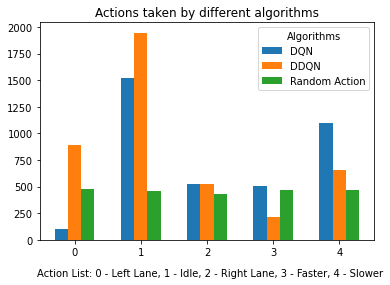

In [ ]:
x = ["0", "1", "2", "3", "4"]
x_axis = np.arange(len(x))
plt.bar(x_axis - 0.2, oneArr, width=0.2, label = 'DQN')
plt.bar(x_axis , twoArr, width=0.2, label = 'DDQN')
plt.bar(x_axis +0.2, threeArr, width=0.2, label = 'Random Action')
plt.title("Actions taken by different algorithms")
plt.legend(title="Algorithms")
plt.figtext(0.52, 0, "Action List: 0 - Left Lane, 1 - Idle, 2 - Right Lane, 3 - Faster, 4 - Slower", horizontalalignment ="center", fontsize = 10)

In [ ]:
mean1 = np.mean(speedDQN)
mean2 = np.mean(speedDDQN)
mean3 = np.mean(speedRandomAction)

print(mean1)
print(mean2)

22.416152169051117
22.94993472257428


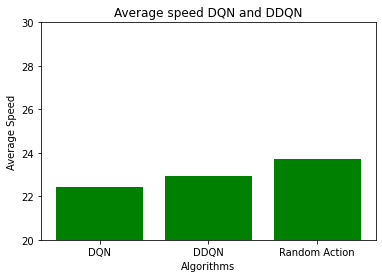

In [ ]:
X = ["DQN", "DDQN", "Random Action"]
Y = [mean1, mean2, mean3]
ax = plt.gca()
plt.bar(X, Y, color='green')
plt.xlabel("Algorithms")
plt.ylabel("Average Speed")
plt.title("Average speed DQN and DDQN")
ax.set_ylim([20, 30])
plt.show()

## Question 5

Will changing the reward system eradicates the emergent behaviour 

In [ ]:
actionDQNChanged = []
actionDDQNChanged = []
actionRandomActionChanged = []

speedDQNChanged = []
speedDDQNChanged = []
speedRandomActionChanged = []

### DQN

In [ ]:
EPISODES = 750
TRAIN_END = 0
DISCOUNT_RATE = 0.8
LEARNING_RATE = 5e-4
BATCH_SIZE = 64
EPSILON_MIN = 0.05
EPSILON_DECAY = 0.995

FILENAME = "drive/MyDrive/here/DQNChanged"
SAVE_EVERY = 100

In [ ]:
env = gym.make('highway-fast-v0')
env.configure({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
    }
})
env.config["reward_speed_range"] = [24,30]
env.config["lane_change_reward"] = 0.4
env.config['high_speed_reward'] =  0.7

env.action_space.np_random.seed(123)
env.seed(50)
nS = len(env.reset().flatten())
nA = env.action_space.n
dqn = DQN(nS, nA, 1)

batch_size = BATCH_SIZE

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
rewardsDQNChanged = [] 
step = 0

for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    done = False
    while not done:
        action = dqn.action(state,env)
        nstate, reward, done, _ = env.step(action)
        nstate = np.reshape(nstate, [1, nS])
        tot_rewards += reward
        dqn.store(state, action, reward, nstate, done)
        state = nstate
        if done:
            rewardsDQNChanged.append(tot_rewards)
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e, EPISODES, tot_rewards, dqn.epsilon))
            break
        if len(dqn.memory) > batch_size:
            dqn.experience_replay(batch_size)
    if step % SAVE_EVERY == 0:
       dqn.save()

    step += 1

episode: 0/750, score: 10.286415565667388, e: 1
episode: 1/750, score: 3.697246230654943, e: 1
episode: 2/750, score: 3.2954587634980372, e: 1
episode: 3/750, score: 9.587226342515454, e: 1
episode: 4/750, score: 12.22989521380573, e: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


episode: 5/750, score: 14.063111102680589, e: 0.9091562615825302
episode: 6/750, score: 4.976371367219871, e: 0.8866535105013078
episode: 7/750, score: 2.0833333333333335, e: 0.8734200960253871
episode: 8/750, score: 2.8120746751470853, e: 0.8603841919146962
episode: 9/750, score: 7.263461024527783, e: 0.8224322824348486
episode: 10/750, score: 3.7821377272331103, e: 0.798065677681905
episode: 11/750, score: 1.997080152498589, e: 0.7861544476842928
episode: 12/750, score: 6.230484650755152, e: 0.7590483508202912
episode: 13/750, score: 6.723973569984729, e: 0.7328768546436799
episode: 14/750, score: 5.186394508555697, e: 0.7076077347272662
episode: 15/750, score: 2.7285616339800702, e: 0.6935613678313175
episode: 16/750, score: 3.1309916736365375, e: 0.6763948591909945
episode: 17/750, score: 2.0833333333333335, e: 0.6662995813682115
episode: 18/750, score: 1.8611111111111114, e: 0.6563549768288433
episode: 19/750, score: 6.421561928898996, e: 0.6337242817644086
episode: 20/750, score:

In [ ]:
open_file = open("drive/MyDrive/here/rewardsDQNChanged.pkl", "wb")
pickle.dump(rewardsDQNChanged, open_file)
open_file.close()

### DDQN

In [ ]:
EPISODES = 750
TRAIN_END = 0
DISCOUNT_RATE = 0.8
LEARNING_RATE = 5e-4
BATCH_SIZE = 64
EPSILON_MIN = 0.05
EPSILON_DECAY = 0.995

FILENAME = "drive/MyDrive/here/DDQNChanged"
SAVE_EVERY = 50

In [ ]:
env = gym.make('highway-fast-v0')
env.configure({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
    }
})
env.config["reward_speed_range"] = [24,30]
env.config["lane_change_reward"] = 0.4
env.config['high_speed_reward'] =  0.7
env.action_space.np_random.seed(123)
env.seed(50)
nS = len(env.reset().flatten())
nA = env.action_space.n
ddqn = DDQN(nS, nA, 1)

batch_size = BATCH_SIZE

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
rewardsDDQNChanged = []
step = 0

for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    done = False
    while not done:
        action = ddqn.action(state,env)
        nstate, reward, done, _ = env.step(action)
        nstate = np.reshape(nstate, [1, nS])
        tot_rewards += reward
        ddqn.store(state, action, reward, nstate, done) # Resize to store in memory to pass to .predict
        state = nstate
        if done:
            rewardsDDQNChanged.append(tot_rewards)
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e, EPISODES, tot_rewards, ddqn.epsilon))
            break
        if len(ddqn.memory) > batch_size:
            ddqn.experience_replay(batch_size)
    

    if e % SAVE_EVERY == 0:
      ddqn.save()
    
    ddqn.update_target_from_model()

    step += 1

episode: 0/750, score: 8.00161814903179, e: 1
episode: 1/750, score: 15.573115184138969, e: 1
episode: 2/750, score: 2.9498400663168556, e: 1
episode: 3/750, score: 12.754939229841291, e: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


episode: 4/750, score: 5.376543224294011, e: 0.9703725093562657
episode: 5/750, score: 3.328696466677364, e: 0.9511101304657719
episode: 6/750, score: 5.625632026319676, e: 0.9229311239742362
episode: 7/750, score: 2.0526357080541446, e: 0.9091562615825302
episode: 8/750, score: 7.318579445484611, e: 0.8734200960253871
episode: 9/750, score: 3.441653322270418, e: 0.851801859600347
episode: 10/750, score: 9.081634647557001, e: 0.8061065909263957
episode: 11/750, score: 6.403408066989815, e: 0.778312557068642
episode: 12/750, score: 1.868370305138921, e: 0.7705488893118823
episode: 13/750, score: 2.4936205413235126, e: 0.7590483508202912
episode: 14/750, score: 4.83642045797052, e: 0.7328768546436799
episode: 15/750, score: 2.0072591940278097, e: 0.7255664080186093
episode: 16/750, score: 6.4646741522835836, e: 0.6935613678313175
episode: 17/750, score: 2.0833333333333335, e: 0.6832098777212641
episode: 18/750, score: 2.374087703751402, e: 0.6696478204705644
episode: 19/750, score: 6.514

In [ ]:
open_file = open("drive/MyDrive/here/rewardsDDQNChanged.pkl", "wb")
pickle.dump(rewardsDDQNChanged, open_file)
open_file.close()

### Training Plots

In [ ]:
open_file = open("drive/MyDrive/here/rewardsDDQNChanged.pkl", "rb")
rewardsDDQNChanged = pickle.load(open_file)
open_file.close()

open_file = open("drive/MyDrive/here/rewardsDQNChanged.pkl", "rb")
rewardsDQNChanged = pickle.load(open_file)
open_file.close()

In [ ]:
one = pd.Series(rewardsDQNChanged, name="scores")
two = pd.Series(rewardsDDQNChanged, name="scores")

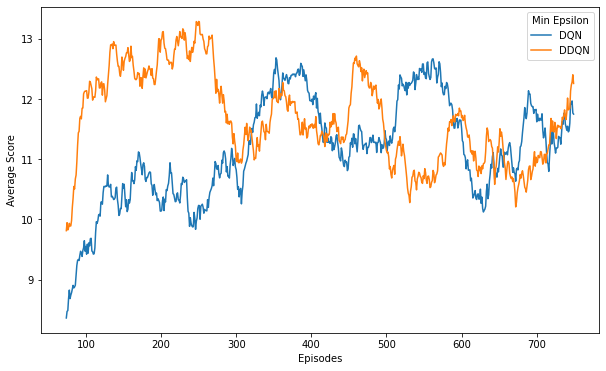

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
_ = (one.rolling(75)
                      .mean()
               .plot(label="DQN"))
_ = (two.rolling(75)
                      .mean()
                      .plot(label="DDQN"))
_ = axes.set_xlabel("Episodes")
_ = axes.set_ylabel("Average Score")
_ = axes.legend(title="Min Epsilon")

### Test

#### DQN Test

In [ ]:
env = gym.make('highway-fast-v0')
env.configure({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
    }
})
env = wrap_env(env, video_callable=lambda episode_id:100)
env.seed(1111)
env.action_space.np_random.seed(123)
nS = len(env.reset().flatten())
nA = env.action_space.n

In [ ]:
TEST_Episodes = 100
FILENAME = directory + "DQNChanged"
dqn = DQN(nS, nA, 1)
dqn.load()
total_reward = 0
step = 0
rewardDQNChanged = []
for e_test in range(TEST_Episodes):
    state = env.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    done = False
    while not done:
        env.render()
        action = dqn.test_action(state)
        actionDQNChanged.append(action)
        nstate, reward, done, info = env.step(action)
        speedDQNChanged.append(info["speed"])
        nstate = np.reshape( nstate, [1, nS])
        tot_rewards += reward
        state = nstate
        if done:
          print(tot_rewards)
          rewardDQNChanged.append(tot_rewards)
          break;
        step += 1

env.close()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23.832044432997126
22.984961689538515
22.919275625073087
24.412867100696605
24.551266118820458
6.4306704772239
11.97723387300938
2.013000696801617
16.710876632339748
15.019778830963663
10.427466483503082
24.852919106036534
22.81657012784016
23.419584974347043
7.778358108019318
18.11168171288285
16.852266072539177
7.7359960840191615
7.19510565877562
24.48115935224955
13.319758810631418
6.544864950680334
21.920175081194827
24.45126313892391
24.177054196858595
20.444877721947982
19.744572404369727
15.3140097218614
21.92022107743573
22.819598886457406
26.34973025654832
13.39676710674866
24.617338637504126
27.38592842204973
24.194906311245223
16.745188968913283
3.848758502420435
7.2118238399565815
5.352581112486322
17.512260934892275
6.629382834342367
24.58450855320779
22.0189327392406
7.1535022448736525
9.353554383031407
7.678197813370915
21.048996786945025
8.745157081721715
3.9797796317649907
22.11955815658314
8.166227026099417
16.846445603116745
23.251328364852796
8.09869084719573
19.312

#### DDQN Test



In [ ]:
env = gym.make('highway-fast-v0')
env.configure({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
    }
})
env = wrap_env(env, video_callable=lambda episode_id:100)
env.seed(1111)
env.action_space.np_random.seed(123)
nS = len(env.reset().flatten())
nA = env.action_space.n

In [ ]:
TEST_Episodes = 100
FILENAME = directory + "DDQNChanged"
ddqn = DDQN(nS, nA, 1)
ddqn.load()
total_reward = 0
step = 0
rewardDDQNChanged = []
for e_test in range(TEST_Episodes):
    state = env.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    done = False
    while not done:
        env.render()
        action = ddqn.test_action(state)
        actionDDQNChanged.append(action)
        nstate, reward, done, info = env.step(action)
        speedDDQNChanged.append(info["speed"])
        nstate = np.reshape( nstate, [1, nS])
        tot_rewards += reward
        state = nstate
        if done:
          print(tot_rewards)
          rewardDDQNChanged.append(tot_rewards)
          break;
        step += 1

env.close()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10.099042902538422
22.285793275789796
4.646446298431657
17.04645040756072
13.310864956764972
5.8464455115174525
11.310908353345688
13.445823678182652
14.543581580718145
15.019778830963663
8.878820324053905
12.046445497630883
2.6461738810591915
6.313112178184118
9.885414851609381
15.745823215051397
4.745203246074302
3.713118245382063
9.209921050491293
1.8801294969714422
23.752931778494098
6.544864950680334
2.8131583425367057
14.599371196868125
8.552880319970651
5.678832033902292
13.978413149025409
22.677399572431348
12.378413772099341
7.263427251034249
22.952931778494104
13.485024754570025
8.382123800934862
15.84644549763033
25.34486429260485
15.412153656900387
3.713118245382063
7.2118238399565815
4.412535619120848
11.177532094825603
6.74515786863592
4.545829296136463
7.245157173289915
5.930670568792097
9.353554383031407
7.544864747788891
8.412649925475343
18.018143372995837
3.9797796317649907
8.886137519122723
8.145157081721717
19.745244261549672
5.378496482252993
5.6131122697523175
3.

#### Random Action Test


In [ ]:
env = gym.make('highway-fast-v0')
env.configure({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
    }
})
env = wrap_env(env, video_callable=lambda episode_id:100)
env.seed(1111)
env.action_space.np_random.seed(123)
nS = len(env.reset().flatten())
nA = env.action_space.n

In [ ]:
TEST_Episodes = 100
total_reward = 0
step = 0
rewardRandomChanged = []
for e_test in range(TEST_Episodes):
    env.reset()
    tot_rewards = 0
    done = False
    while not done:
        env.render()
        action = random.randrange(5)
        actionRandomActionChanged.append(action)
        nstate, reward, done, info = env.step(action)
        speedRandomActionChanged.append(info["speed"])
        tot_rewards += reward
        if done:
          print(tot_rewards)
          rewardRandomChanged.append(tot_rewards)
          break;
        step += 1

env.close()

9.385881380414085
4.149689594732289
2.812840547725858
7.182792275158974
18.24979213924449
8.998516365244695
3.812073739913873
14.399117737082985
2.6842786364643705
12.449627176595886
1.666044718341951
9.48192322653438
4.099377276904825
6.313112178184118
8.682330112193904
3.586887034901676
7.2809334699442925
3.734181867889313
8.235366446540016
6.449145110848586
1.6666666666666667
14.414873548474793
2.7798250092033725
6.448847899174032
23.427395802071338
23.298069351214046
8.518012420541694
1.665465357980372
10.028956109107803
3.530254224657067
4.832710609457763
2.515152310877697
3.4812396645101993
4.5845294534745165
21.385088582527906
3.3177273217318817
4.280129496971441
2.049108367626886
6.78159577706288
4.380174874409824
9.17951958737528
21.25037374858474
4.945358465043899
5.644409112400852
9.01665070225654
9.332789529676777
23.295940246659054
1.0196670561736862
3.6128405477258587
3.4790446415282106
7.68363657131134
9.767767114166737
16.632130181974826
9.64597478021956
3.9849929513896

#### Saving Logs

In [ ]:
open_file = open(directory + "actionDQNChanged.pkl", "wb")
pickle.dump(actionDQNChanged, open_file)
open_file.close()

open_file = open(directory + "actionDDQNChanged.pkl", "wb")
pickle.dump(actionDDQNChanged, open_file)
open_file.close()

open_file = open(directory + "actionRandomActionChanged.pkl", "wb")
pickle.dump(actionRandomActionChanged, open_file)
open_file.close()

open_file = open(directory + "speedDQNChanged.pkl", "wb")
pickle.dump(speedDQNChanged, open_file)
open_file.close()

open_file = open(directory + "speedDDQNChanged.pkl", "wb")
pickle.dump(speedDDQNChanged, open_file)
open_file.close()

open_file = open(directory + "speedRandomActionChanged.pkl", "wb")
pickle.dump(speedRandomActionChanged, open_file)
open_file.close()

open_file = open(directory + "rewardDQNChanged.pkl", "wb")
pickle.dump(rewardDQNChanged, open_file)
open_file.close()

open_file = open(directory + "rewardDDQNChanged.pkl", "wb")
pickle.dump(rewardDDQNChanged, open_file)
open_file.close()

open_file = open(directory + "rewardRandomChanged.pkl", "wb")
pickle.dump(rewardRandomChanged, open_file)
open_file.close()

### Plots

Loading Logs

In [ ]:
open_file = open(directory + "actionDQNChanged.pkl", "rb")
actionDQNChanged = pickle.load(open_file)
open_file.close()

open_file = open(directory + "actionDDQNChanged.pkl", "rb")
actionDDQNChanged = pickle.load(open_file)
open_file.close()

open_file = open(directory + "actionRandomActionChanged.pkl", "rb")
actionRandomActionChanged = pickle.load(open_file)
open_file.close()

open_file = open(directory + "speedDQNChanged.pkl", "rb")
speedDQNChanged = pickle.load(open_file)
open_file.close()

open_file = open(directory + "speedDDQNChanged.pkl", "rb")
speedDDQNChanged = pickle.load(open_file)
open_file.close()

open_file = open(directory + "speedRandomActionChanged.pkl", "rb")
speedRandomActionChanged = pickle.load(open_file)
open_file.close()

open_file = open(directory + "rewardDQNChanged.pkl", "rb")
rewardDQNChanged = pickle.load(open_file)
open_file.close()

open_file = open(directory + "rewardDDQNChanged.pkl", "rb")
rewardDDQNChanged = pickle.load(open_file)
open_file.close()

open_file = open(directory + "rewardRandomChanged.pkl", "rb")
rewardRandomChanged = pickle.load(open_file)
open_file.close()

In [ ]:
one = pd.Series(actionDQNChanged, name="rewards").value_counts()
two = pd.Series(actionDDQNChanged, name="rewards").value_counts()
three = pd.Series(actionRandomActionChanged, name="rewards").value_counts()

[one[i] if i in one else 0 for i in range(5)]
[two[i] if i in two else 0 for i in range(5)]

oneArr = [one[0], one[1], one[2], one[3], one[4]]
twoArr = [two[0], two[1], two[2], two[3], two[4]]
threeArr = [three[0], three[1], three[2], three[3], three[4]]

Text(0.52, 0, 'Action List: 0 - Left Lane, 1 - Idle, 2 - Right Lane, 3 - Faster, 4 - Slower')

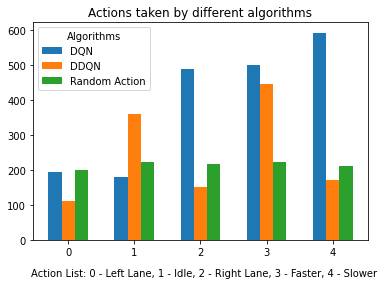

In [ ]:
x = ["0", "1", "2", "3", "4"]
x_axis = np.arange(len(x))
plt.bar(x_axis - 0.2, oneArr, width=0.2, label = 'DQN')
plt.bar(x_axis , twoArr, width=0.2, label = 'DDQN')
plt.bar(x_axis +0.2, threeArr, width=0.2, label = 'Random Action')
plt.title("Actions taken by different algorithms")
plt.legend(title="Algorithms")
plt.figtext(0.52, 0, "Action List: 0 - Left Lane, 1 - Idle, 2 - Right Lane, 3 - Faster, 4 - Slower", horizontalalignment ="center", fontsize = 10)

In [ ]:
mean1 = np.mean(speedDQNChanged)
mean2 = np.mean(speedDDQNChanged)
mean3 = np.mean(speedRandomActionChanged)

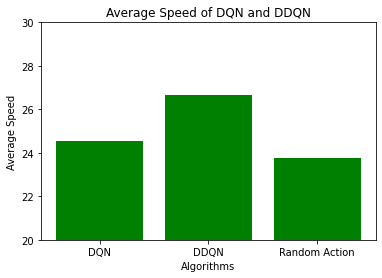

In [ ]:
X = ["DQN", "DDQN", "Random Action"]
Y = [mean1, mean2, mean3]
ax = plt.gca()
plt.bar(X, Y, color='green')
plt.xlabel("Algorithms")
plt.ylabel("Average Speed")
plt.title("Average Speed of DQN and DDQN")
ax.set_ylim([20, 30])
plt.show()

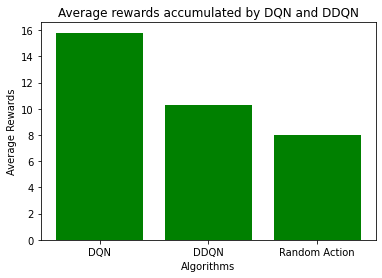

In [ ]:
mean1 = np.mean(rewardDQNChanged)
mean2 = np.mean(rewardDDQNChanged)
mean3 = np.mean(rewardRandomChanged)

X = ["DQN", "DDQN", "Random Action"]
Y = [mean1, mean2, mean3]

plt.bar(X, Y, color='green')
plt.xlabel("Algorithms")
plt.ylabel("Average Rewards")
plt.title("Average rewards accumulated by DQN and DDQN")

plt.show()

## Show Videos

In [ ]:
show_videos()


SHOWING VIDEO video/openaigym.video.8.74.video000000.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000001.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000002.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000003.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000004.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000005.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000006.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000007.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000008.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000009.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000010.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000011.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000012.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000013.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000014.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000015.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000016.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000017.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000018.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000019.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000020.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000021.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000022.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000023.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000024.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000025.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000026.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000027.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000028.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000029.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000030.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000031.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000032.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000033.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000034.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000035.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000036.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000037.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000038.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000039.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000040.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000041.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000042.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000043.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000044.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000045.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000046.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000047.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000048.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000049.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000050.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000051.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000052.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000053.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000054.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000055.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000056.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000057.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000058.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000059.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000060.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000061.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000062.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000063.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000064.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000065.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000066.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000067.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000068.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000069.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000070.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000071.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000072.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000073.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000074.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000075.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000076.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000077.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000078.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000079.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000080.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000081.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000082.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000083.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000084.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000085.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000086.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000087.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000088.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000089.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000090.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000091.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000092.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000093.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000094.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000095.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000096.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000097.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000098.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000099.mp4



SHOWING VIDEO video/openaigym.video.8.74.video000100.mp4
